#NEURAL NETWORKS AND DEEP LEARNING

## Homework 3 - Deep Reinforcement Learning

### Cart-Pole environment using pixels

Puppin Michele - 1227474

In [ ]:
# Install libraries
!pip install gym
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

In [ ]:
# Import packages
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import files
import cv2

import torch
from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Enable gym environment rendering in Colab

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Network definition

In [ ]:
class DQN(nn.Module):

    def __init__(self, channels, lin_input, action_space_dim):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = channels, out_channels = 64, kernel_size = 4, stride = 2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            )
                
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(lin_input, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
            )
        

    def forward(self, x):
        x = self.conv(x)
        return self.linear(x)

## Exploration Policy

In [ ]:
# Epsilon-greedy policy
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state.to(device)).cpu()

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

# Softmax policy
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state.to(device)).cpu()

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out[0] / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

## Update function

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    #states      = torch.tensor([s[0][0] for s in batch], dtype=torch.float32)
    states      = torch.stack([s[0][0] for s in batch])
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    #non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_next_states = torch.stack([s[2][0] for s in batch if s[2] is not None]) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states.to(device)).cpu()
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states.to(device)).cpu()
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

### Image extraction

In [ ]:
def image_extraction(screen):
    screen = screen[170:290,:,2] # Crop the image and select one colour channel
    screen = cv2.resize(screen, (200, 100), interpolation=cv2.INTER_CUBIC)
    screen = screen[np.newaxis,:]
    screen = torch.tensor(screen.copy(), dtype=torch.float32)
    return screen.unsqueeze(0) 

## Train with best parameters

torch.Size([1, 1, 100, 200])


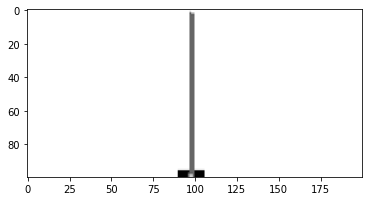

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

env.reset()
screen = env.render(mode='rgb_array')
screen = image_extraction(screen)
env.close()

print(screen.shape)
plt.imshow(screen.cpu().squeeze().numpy(), cmap = 'gray')
plt.show()

In [ ]:
best_params = {'beta': 15,
          'gamma': 0.98,            
          'lr': 1e-1,          
          }

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * best_params['beta']) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

In [ ]:
### PARAMETERS
gamma = best_params['gamma']   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = best_params['lr']   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

channels = 1
lin_input = 30912

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(channels, lin_input, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(channels, lin_input, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

final_score_log = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    screen = image_extraction(env.render(mode='rgb_array'))

    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, screen, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      next_screen = image_extraction(env.render(mode='rgb_array'))

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None
          next_screen = None 

      if type(next_state) != "NoneType":
          next_screen = image_extraction(env.render(mode='rgb_array'))

      # Update the replay memory
      replay_mem.push(screen, action, next_screen, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state
      screen = next_screen

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        #print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    #print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    final_score_log.append(score)

env.close()

In [ ]:
# Plot scores
plt.figure(figsize=(12,8))
plt.plot(final_score_log)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

plt.savefig('Score_CPsp.pdf', bbox_inches='tight')
files.download('Score_CPsp.pdf')
plt.show()

### Multiple frames

In [ ]:
# Softmax policy
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state.to(device)).cpu().squeeze(0)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.from_numpy(np.array( [s[0] for s in batch], dtype=np.float32 ))
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states =  torch.from_numpy(np.array([s[2] for s in batch if s[2] is not None], dtype=np.float32)) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states.to(device)).cpu()
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states.to(device)).cpu()
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)
    # Create tensors for each element of the batch
    states  = np.array( [s[0] for s in batch], dtype=np.float32 )
    states = torch.from_numpy(states)
    actions = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards = torch.tensor([s[3] for s in batch], dtype=torch.float32)
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states =  np.array([s[2] for s in batch if s[2] is not None], dtype=np.float32)# the next state can be None if the game has ended
    non_final_next_states = torch.from_numpy(non_final_next_states)
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)
    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states.to(device)).cpu()
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))
    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states.to(device)).cpu()
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape
    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [ ]:
def image_extraction(screen):
    screen = screen[170:290,:,2] # Crop the image and select one colour channel
    screen = cv2.resize(screen, (200, 170), interpolation=cv2.INTER_CUBIC)
    screen = screen[np.newaxis,:]
    return screen

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

channels = 4 
lin_input = 57408

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(channels, lin_input, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN( channels, lin_input, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

ml = 3
screen_history = deque(maxlen=ml)

final_score_log = []

for i in range(ml): screen_history.append(np.zeros((1, 170, 200) ))

for episode_num, tau in enumerate(tqdm(exploration_profile)):
    # Reset the environment and get the initial state
    state = env.reset()
    screen = image_extraction(env.render(mode='rgb_array'))
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off
    for i in range(ml):
        screen = np.append( screen, screen_history[-i-1], axis=0)
    st = 0
    while not done:
        # Adding history
        for i in range(ml):
            if screen_history[i] is None: screen_history[i] = np.zeros((1, 170, 200) )
        
        screen_history.append(screen[0][np.newaxis, :])
        
        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, torch.tensor(screen).type(torch.float).unsqueeze(0), temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        next_screen = image_extraction(env.render(mode='rgb_array'))
        
        for i in range(ml):
            next_screen = np.append( next_screen, screen_history[-i-1], axis=0) 
        
        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += 1
        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
            next_screen = None

        # Update the replay memory
        replay_mem.push(screen, action, next_screen, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Set the current state for the next iteration
        screen = next_screen
        state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        #print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    #print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    final_score_log.append(score)

env.close()

In [ ]:
# Plot scores
plt.figure(figsize=(12,8))
plt.plot(final_score_log)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

plt.savefig('Score_CPsp.pdf', bbox_inches='tight')
files.download('Score_CPsp.pdf')
plt.show()